In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Combined Google Stock Data:
           Date    Open    High     Low   Close      Volume
0    2012-01-03  325.25  332.83  324.97  663.59   7380500.0
1    2012-01-04  331.27  333.87  329.08  666.45   5749400.0
2    2012-01-05  329.83  330.75  326.89  657.21   6590300.0
3    2012-01-06  328.34  328.77  323.68  648.24   5405900.0
4    2012-01-09  322.04  322.29  309.46  620.76  11688800.0
...         ...     ...     ...     ...     ...         ...
1273 2017-01-25  829.62  835.77  825.06  835.67   1494500.0
1274 2017-01-26  837.81  838.00  827.01  832.15   2973900.0
1275 2017-01-27  834.71  841.95  820.44  823.31   2965800.0
1276 2017-01-30  814.66  815.84  799.80  802.32   3246600.0
1277 2017-01-31  796.86  801.25  790.52  796.79   2160600.0

[1278 rows x 6 columns]
Google Stock Data Shape: (1278, 6)


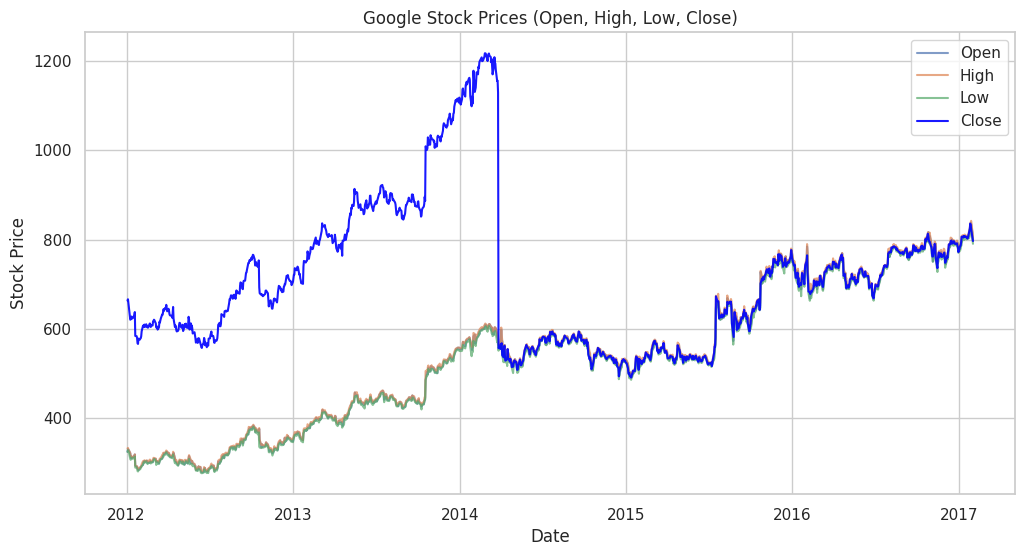

Adjusted Close Prices (First 10 rows):
        Date       Close
0 2012-01-03  331.463536
1 2012-01-04  332.892108
2 2012-01-05  328.276723
3 2012-01-06  323.796204
4 2012-01-09  310.069930
5 2012-01-10  310.404595
6 2012-01-11  311.813187
7 2012-01-12  313.646354
8 2012-01-13  311.328671
9 2012-01-17  313.116883


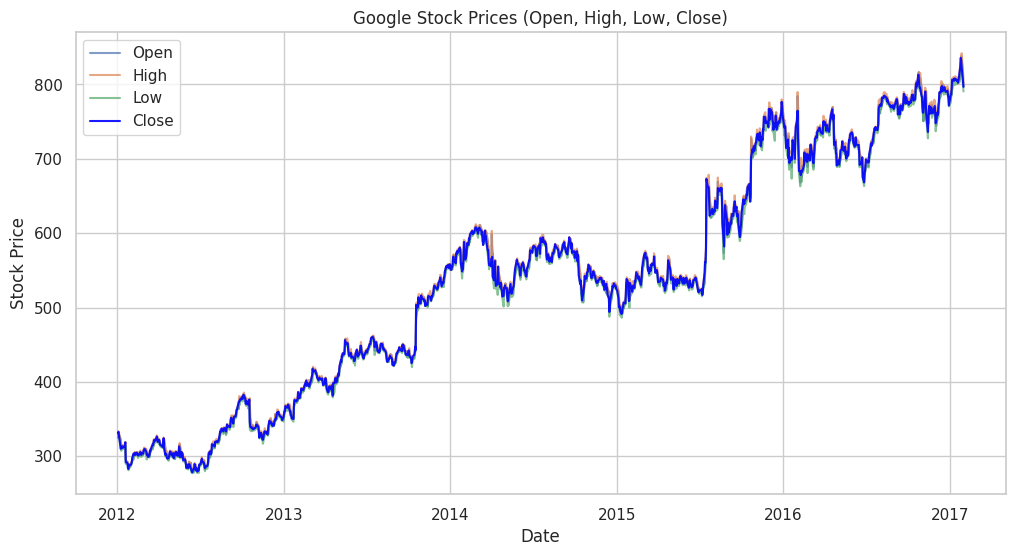

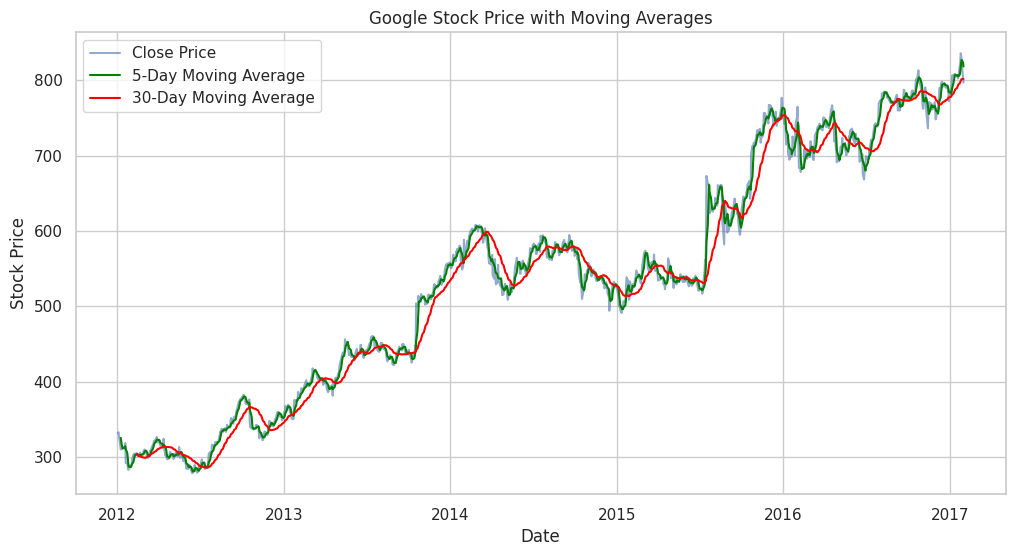

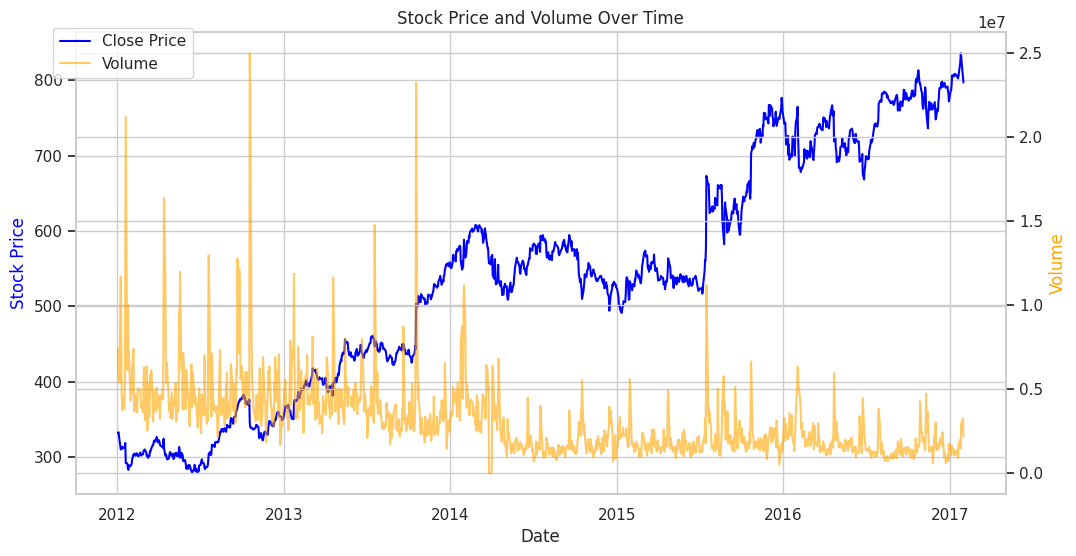

<Figure size 1200x800 with 0 Axes>

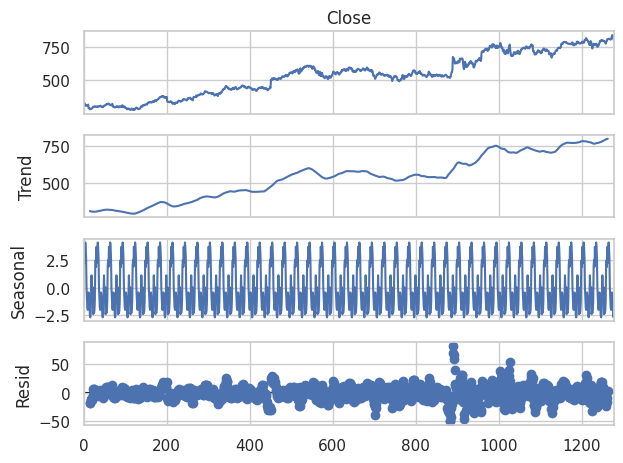

<Figure size 1200x800 with 0 Axes>

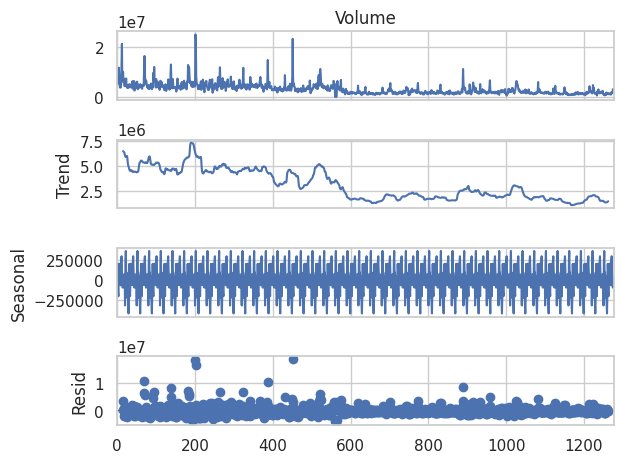

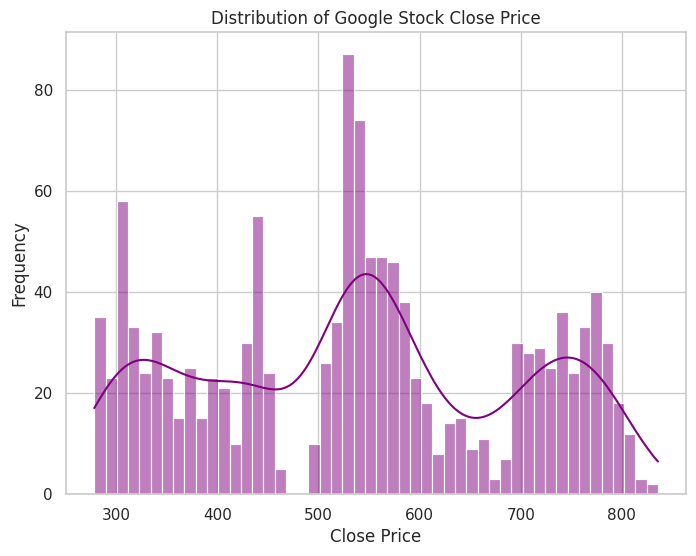

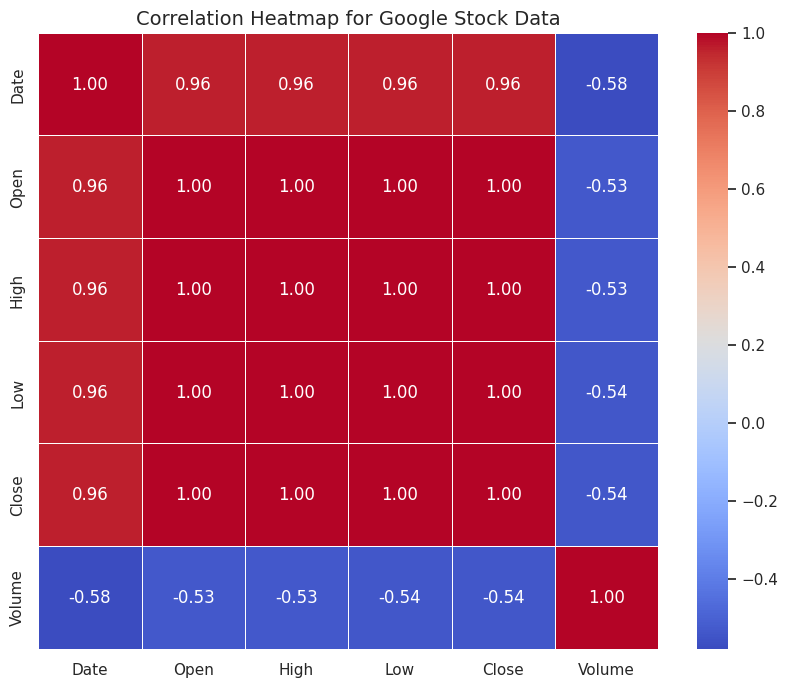

In [34]:
# Impleminnting RNN GRU and LSTM Models prediction on Google Stock Data with (N=5,M=1) and (N=30,M=3) days sequence length
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Set plot style for visualization
sns.set(style="whitegrid")

# Load datasets
train_data = pd.read_csv('/content/drive/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('/content/drive/Google_Stock_Price_Test.csv')


# Preprocessing by removing commas and converting values types to numeric
train_data['Close'] = train_data['Close'].str.replace(',', '').astype(float)
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(float)

# Convert the Date column to datetime format
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%m/%d/%Y')
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%m/%d/%Y')

# Combine train_data and test_data to gether for resplitting
google_stock_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

# Print a samples of the combined datasets
print("Combined Google Stock Data:")
print(google_stock_data)

# Check combined data shape
print("Google Stock Data Shape:", google_stock_data.shape)

# To make a line plot for Open, High, Low, and Close prices before removing Stock prices split effect on Close price before 27/03/2024
plt.figure(figsize=(12, 6))
plt.plot(google_stock_data['Date'], google_stock_data['Open'], label='Open', alpha=0.7)
plt.plot(google_stock_data['Date'], google_stock_data['High'], label='High', alpha=0.7)
plt.plot(google_stock_data['Date'], google_stock_data['Low'], label='Low', alpha=0.7)
plt.plot(google_stock_data['Date'], google_stock_data['Close'], label='Close', alpha=0.9, color='blue')
plt.title('Google Stock Prices (Open, High, Low, Close)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Define split date based on https://companiesmarketcap.com/alphabet-google/stock-splits/
split_date = pd.Timestamp('2014-03-27')  # Google stock price split date

# Adjust Close prices before 27/03/2014 (Divide by 2.002)
google_stock_data.loc[google_stock_data['Date'] < split_date, 'Close'] /= 2.002

# Verify adjustment
print("Adjusted Close Prices (First 10 rows):")
print(google_stock_data[['Date', 'Close']].head(10))

# Save the adjusted data
google_stock_data.to_csv('/content/drive/Google_Stock_Data_Adjusted.csv', index=False)

# To make a line plot for Open, High, Low, and Close prices after removing Stock prices split effect on Close price to align with other features
plt.figure(figsize=(12, 6))
plt.plot(google_stock_data['Date'], google_stock_data['Open'], label='Open', alpha=0.7)
plt.plot(google_stock_data['Date'], google_stock_data['High'], label='High', alpha=0.7)
plt.plot(google_stock_data['Date'], google_stock_data['Low'], label='Low', alpha=0.7)
plt.plot(google_stock_data['Date'], google_stock_data['Close'], label='Close', alpha=0.9, color='blue')
plt.title('Google Stock Prices (Open, High, Low, Close)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# To implement Moving Averages to identify trends
# Calculate 20-day and 30-day and 60-day moving averages
google_stock_data['MA05'] = google_stock_data['Close'].rolling(window=5).mean()
google_stock_data['MA30'] = google_stock_data['Close'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(google_stock_data['Date'], google_stock_data['Close'], label='Close Price', alpha=0.6)
plt.plot(google_stock_data['Date'], google_stock_data['MA05'], label='5-Day Moving Average', color='green')
plt.plot(google_stock_data['Date'], google_stock_data['MA30'], label='30-Day Moving Average', color='red')
plt.title('Google Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Show Trading Volume Analysis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(google_stock_data['Date'], google_stock_data['Close'], label='Close Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color='blue')
ax2 = ax1.twinx()
ax2.plot(google_stock_data['Date'], google_stock_data['Volume'], label='Volume', color='orange', alpha=0.6)
ax2.set_ylabel('Volume', color='orange')

plt.title('Stock Price and Volume Over Time')
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()

# To apply seasonal decomposition to identify trends and seasonality
# Decompose the Close price time series into trend, seasonality, and residuals for close for 30 days
result_close = seasonal_decompose(google_stock_data['Close'], model='additive', period=30)

# Plot the decomposition
plt.figure(figsize=(12, 8))
result_close.plot()
plt.show()

# Decompose the Volume price time series into trend, seasonality, and residuals for close for 30 days
result_volume = seasonal_decompose(google_stock_data['Volume'], model='additive', period=30)

# Plot the decomposition
plt.figure(figsize=(12, 8))
result_volume.plot()
plt.show()

# Histogram of Close Stock Prices
plt.figure(figsize=(8, 6))
sns.histplot(google_stock_data['Close'], bins=50, kde=True, color='purple')
plt.title('Distribution of Google Stock Close Price')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# Drop the already created columns for analyisis
google_stock_data = google_stock_data.drop(columns=['MA05', 'MA30'])

# Compute the correlation matrix
correlation_matrix = google_stock_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Google Stock Data", fontsize=14)
plt.show()

In [35]:
# Google Stock Data splitting and preprocessing for time-series prediction

# Drop the 'Date' and 'Volume' column tkeep stock prices onlt for training
google_stock_data = google_stock_data.drop(columns=['Date', 'Volume'])
print("Google stock prices data:", google_stock_data)

# Extract all features for modeling
data_values = google_stock_data.values

# Calculate split indices for 70% training, 10% validating and 20% testing
train_size = int(0.7 * len(data_values))
val_size = int(0.1 * len(data_values))
test_size = len(data_values) - train_size - val_size

# Split data into train, validation, and test sets in chronological order for time series prediction
train_set = data_values[:train_size]
val_set = data_values[train_size:train_size + val_size]
test_set = data_values[train_size + val_size:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = scaler.fit_transform(train_set) # Only fit_tranform the train set to avoid bias
val_set_scaled = scaler.transform(val_set)
test_set_scaled = scaler.transform(test_set)

# Print datasets shapes to confirm
print(f"Train set shape: {train_set_scaled.shape}")
print(f"Validation set shape: {val_set_scaled.shape}")
print(f"Test set shape: {test_set_scaled.shape}")

# Function to create sequences
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(N, len(data) - M + 1):
        X.append(data[i-N:i, :])  # Past N days
        y.append(data[i:i+M, :])  # Next M days
    return np.array(X), np.array(y)

# Set N (input sequence length) and M (output sequence length)
N = 5  # For past 5 days
M = 1   # to predict the next day

# Create sequences for train, validation, and test sets
X_train, y_train = create_sequences(train_set_scaled, N, M)
X_val, y_val = create_sequences(val_set_scaled, N, M)
X_test, y_test = create_sequences(test_set_scaled, N, M)

# Print shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# To set reproducibility seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# To ensure inputs are 3D (batch_size, sequence_length, input_size) for the training process
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

# Print shapes after reshaping data into 3D
print("\nAfter reshaping data to (batch_size, sequence_length, input_size):")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Google stock prices data:         Open    High     Low       Close
0     325.25  332.83  324.97  331.463536
1     331.27  333.87  329.08  332.892108
2     329.83  330.75  326.89  328.276723
3     328.34  328.77  323.68  323.796204
4     322.04  322.29  309.46  310.069930
...      ...     ...     ...         ...
1273  829.62  835.77  825.06  835.670000
1274  837.81  838.00  827.01  832.150000
1275  834.71  841.95  820.44  823.310000
1276  814.66  815.84  799.80  802.320000
1277  796.86  801.25  790.52  796.790000

[1278 rows x 4 columns]
Train set shape: (894, 4)
Validation set shape: (127, 4)
Test set shape: (257, 4)
X_train shape: (889, 5, 4), y_train shape: (889, 1, 4)
X_val shape: (122, 5, 4), y_val shape: (122, 1, 4)
X_test shape: (252, 5, 4), y_test shape: (252, 1, 4)

After reshaping data to (batch_size, sequence_length, input_size):
X_train shape: torch.Size([889, 5, 4]), y_train shape: torch.Size([889, 1, 4])
X_val shape: torch.Size([122, 5, 4]), y_val shape: torch.Size([122, 1

In [36]:
# Define Vanilla RNN, GRU, and LSTM Models
# Some parts of the code are inspired from https://github.com/RodolfoLSS/stock-prediction-pytorch/blob/master/stock-prediction-pytorch.ipynb

class VanillaRNNPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, M, dropout_prob=0.2):
        super(VanillaRNNPredictor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, M* output_size)
        self.M = M
        self.output_size = output_size

    def forward(self,x):
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:,-1,:]) # Shape: (batch_size, M*output_size)
        # Reshape output to (batch_size, M, output_size)
        out = out.view(-1,self.M, self.output_size)
        return out

class GRUPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, M, dropout_prob=0.2):
        super(GRUPredictor, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, M* output_size)
        self.M = M
        self.output_size = output_size

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = out.view(-1, self.M, self.output_size)
        return out

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, M, dropout_prob=0.2):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, M * output_size)
        self.M = M
        self.output_size = output_size

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = out.view(-1, self.M, self.output_size)
        return out

In [37]:
# Training and Evaluation Function
# Some parts of the code are inspired from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, M, hidden_size, num_layers, learning_rate, epochs, batch_size):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)
    train_losses, val_losses = [], []

    # DataLoader
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss= 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()

        # Record metrics
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        print(f'{model_name} Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.suptitle(f'{model_name} Training and Validation Loss with {hidden_size} hidden size, {num_layers} num_layers, '
             f'{learning_rate} learning rate, {epochs} epochs and {batch_size} batch size', fontsize=12, y=0.95)
    plt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    # Evaluate on Test Set
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.to(device)).cpu().numpy()
        actuals = y_test.cpu().numpy()

        # Handle inverse scaling for multi step prediction plots
        preds = predictions.reshape(-1, M, predictions.shape[-1])
        acts = actuals.reshape(-1, M, actuals.shape[-1])

        # Perform inverse scaling for preds and acts
        preds = scaler.inverse_transform(preds.reshape(-1, preds.shape[-1]))
        acts = scaler.inverse_transform(acts.reshape(-1, acts.shape[-1]))

    # Perform inverse scaling for predictions and actuals to calculate meterics
    predictions_inv = scaler.inverse_transform(predictions.reshape(-1, predictions.shape[-1]))
    actuals_inv = scaler.inverse_transform(actuals.reshape(-1, actuals.shape[-1]))

    # Calculate evaluation metrics on inverse-scaled data
    mse = mean_squared_error(actuals_inv.reshape(-1), predictions_inv.reshape(-1))
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals_inv.reshape(-1), predictions_inv.reshape(-1))

    # Calculate evaluation metrics on scaled data
    # mse = mean_squared_error(actuals.reshape(-1), predictions.reshape(-1))
    # rmse = np.sqrt(mse)
    # mae = mean_absolute_error(actuals.reshape(-1), predictions.reshape(-1))

    print(f'{model_name} with {hidden_size} hidden size, {num_layers} num_layers, {learning_rate} lr, {epochs} epochs and {batch_size} batch size:\nTest MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

    # Plot Open and Close prices predictions
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Open Prices (Actual vs Predicted)
    axes[0].plot(acts[:, 0], label='Actual (Open)', color='blue', linestyle='--')
    axes[0].plot(preds[:, 0], label='Predicted (Open)', color='blue')
    axes[0].set_title('Actual vs Predicted Open Prices')
    axes[0].set_xlabel('Time (days)')
    axes[0].set_ylabel('Open Price')
    axes[0].legend()

    # Close Prices (Actual vs Predicted)
    axes[1].plot(acts[:, 3], label='Actual (Close)', color='green', linestyle='--')
    axes[1].plot(preds[:, 3], label='Predicted (Close)', color='green')
    axes[1].set_title('Actual vs Predicted Close Prices')
    axes[1].set_xlabel('Time (days)')
    axes[1].set_ylabel('Close Price')
    axes[1].legend()

    fig.suptitle(f'{model_name} {M}-Step Prediction for Open and Close Prices\nwith {hidden_size} hidden size, '
             f'{num_layers} num_layers, {learning_rate} learning rate, {epochs} epochs and {batch_size} batch size',
             fontsize=12, y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


Running Vanilla RNN with hidden_size=32, num_layers=1, dropout_rate=0.2, learning_rate=0.01, batch_size=32 and epochs=50:
Vanilla RNN Epoch 1/50, Train Loss: 0.0422, Val Loss: 0.0140
Vanilla RNN Epoch 2/50, Train Loss: 0.0013, Val Loss: 0.0127


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Vanilla RNN Epoch 3/50, Train Loss: 0.0004, Val Loss: 0.0083
Vanilla RNN Epoch 4/50, Train Loss: 0.0004, Val Loss: 0.0063
Vanilla RNN Epoch 5/50, Train Loss: 0.0004, Val Loss: 0.0054
Vanilla RNN Epoch 6/50, Train Loss: 0.0004, Val Loss: 0.0025
Vanilla RNN Epoch 7/50, Train Loss: 0.0003, Val Loss: 0.0040
Vanilla RNN Epoch 8/50, Train Loss: 0.0003, Val Loss: 0.0039
Vanilla RNN Epoch 9/50, Train Loss: 0.0003, Val Loss: 0.0032
Vanilla RNN Epoch 10/50, Train Loss: 0.0003, Val Loss: 0.0029
Vanilla RNN Epoch 11/50, Train Loss: 0.0003, Val Loss: 0.0027
Vanilla RNN Epoch 12/50, Train Loss: 0.0003, Val Loss: 0.0033
Vanilla RNN Epoch 13/50, Train Loss: 0.0004, Val Loss: 0.0048
Vanilla RNN Epoch 14/50, Train Loss: 0.0003, Val Loss: 0.0017
Vanilla RNN Epoch 15/50, Train Loss: 0.0003, Val Loss: 0.0054
Vanilla RNN Epoch 16/50, Train Loss: 0.0003, Val Loss: 0.0022
Vanilla RNN Epoch 17/50, Train Loss: 0.0003, Val Loss: 0.0017
Vanilla RNN Epoch 18/50, Train Loss: 0.0003, Val Loss: 0.0023
Vanilla RNN Epo

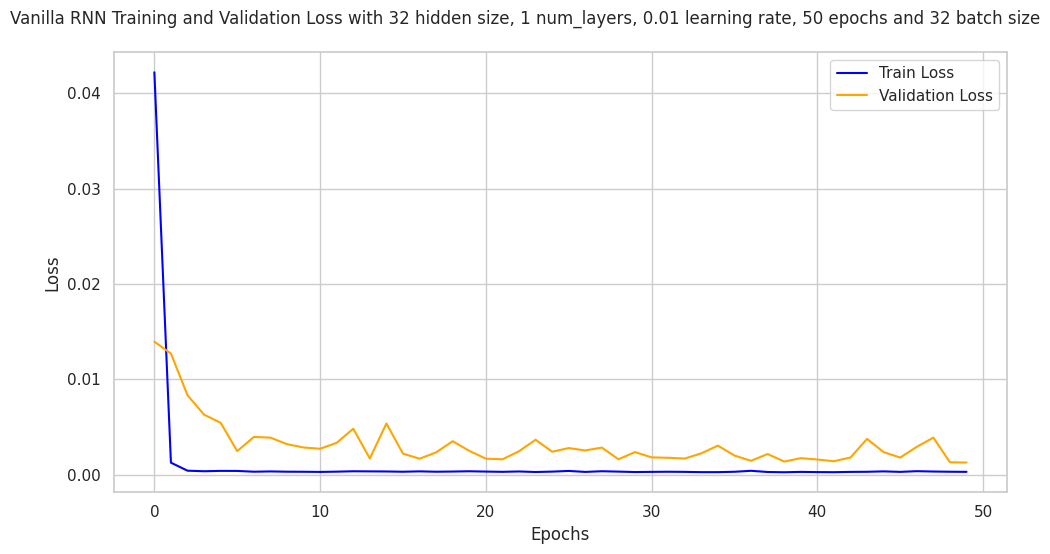

Vanilla RNN with 32 hidden size, 1 num_layers, 0.01 lr, 50 epochs and 32 batch size:
Test MSE: 272.3560, RMSE: 16.5032, MAE: 14.4978


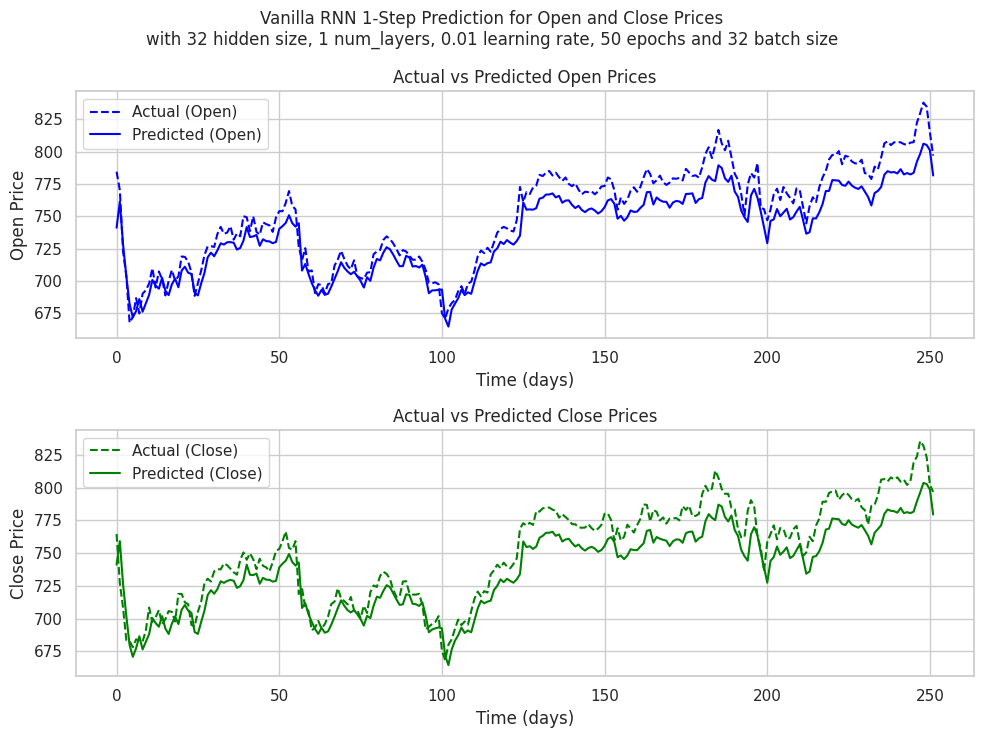

Running GRU with hidden_size=32, num_layers=2, dropout_rate=0.2, learning_rate=0.01, batch_size=32 and epochs=50:
GRU Epoch 1/50, Train Loss: 0.0564, Val Loss: 0.0255
GRU Epoch 2/50, Train Loss: 0.0038, Val Loss: 0.0398
GRU Epoch 3/50, Train Loss: 0.0020, Val Loss: 0.0223
GRU Epoch 4/50, Train Loss: 0.0016, Val Loss: 0.0220
GRU Epoch 5/50, Train Loss: 0.0013, Val Loss: 0.0211
GRU Epoch 6/50, Train Loss: 0.0013, Val Loss: 0.0149
GRU Epoch 7/50, Train Loss: 0.0016, Val Loss: 0.0187
GRU Epoch 8/50, Train Loss: 0.0013, Val Loss: 0.0193
GRU Epoch 9/50, Train Loss: 0.0012, Val Loss: 0.0109
GRU Epoch 10/50, Train Loss: 0.0012, Val Loss: 0.0112
GRU Epoch 11/50, Train Loss: 0.0010, Val Loss: 0.0068
GRU Epoch 12/50, Train Loss: 0.0010, Val Loss: 0.0048
GRU Epoch 13/50, Train Loss: 0.0013, Val Loss: 0.0181
GRU Epoch 14/50, Train Loss: 0.0013, Val Loss: 0.0086
GRU Epoch 15/50, Train Loss: 0.0009, Val Loss: 0.0095
GRU Epoch 16/50, Train Loss: 0.0008, Val Loss: 0.0089
GRU Epoch 17/50, Train Loss: 0.

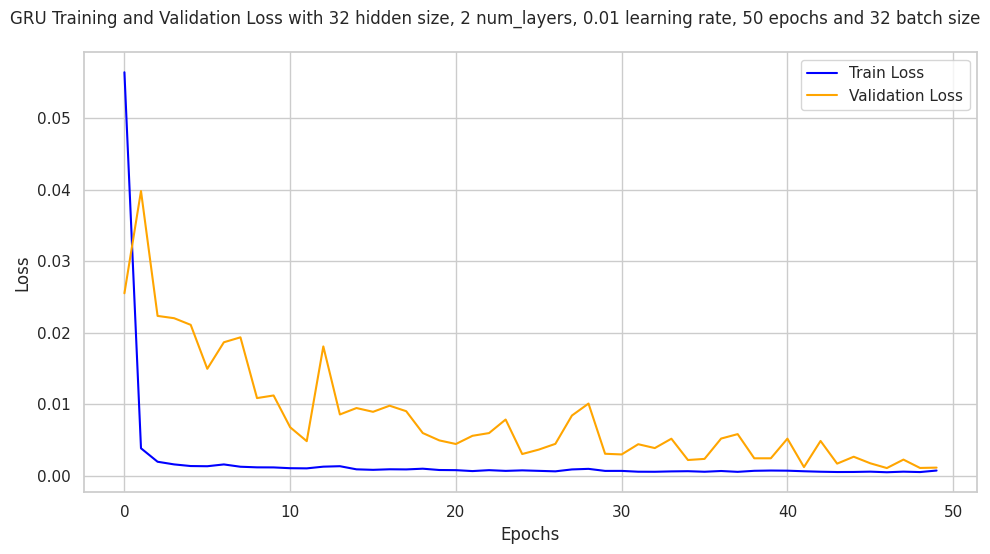

GRU with 32 hidden size, 2 num_layers, 0.01 lr, 50 epochs and 32 batch size:
Test MSE: 253.7490, RMSE: 15.9295, MAE: 12.7198


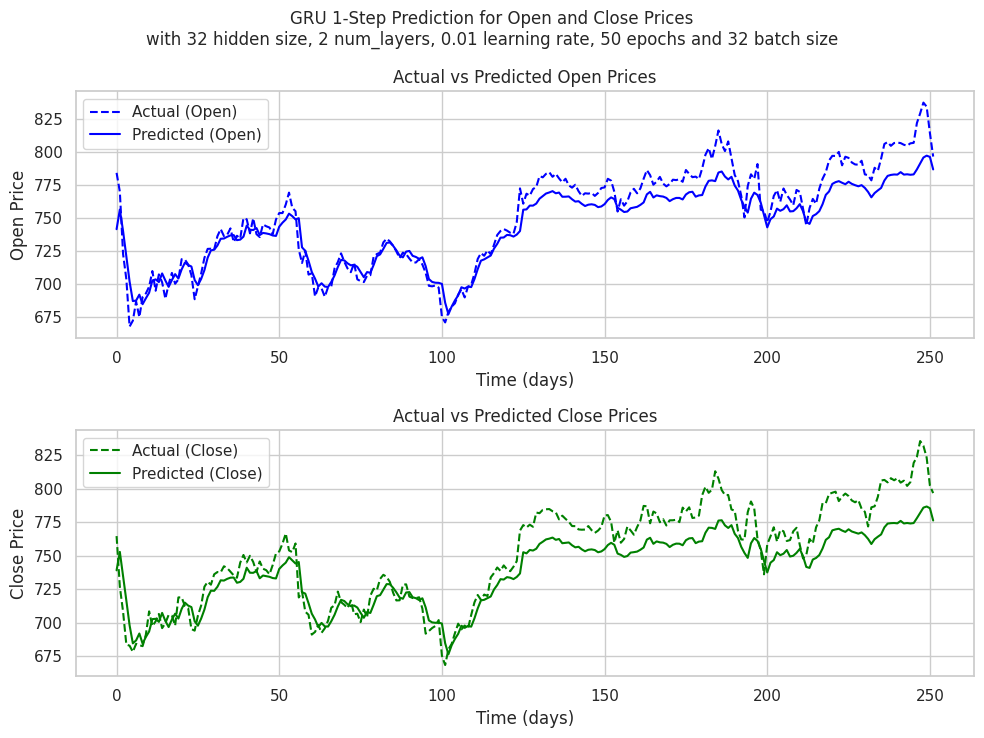

Running LSTM with hidden_size=64, num_layers=2, dropout_rate=0.2, learning_rate=0.01, batch_size=32 and epochs=50:
LSTM Epoch 1/50, Train Loss: 0.0462, Val Loss: 0.0817
LSTM Epoch 2/50, Train Loss: 0.0020, Val Loss: 0.0504
LSTM Epoch 3/50, Train Loss: 0.0015, Val Loss: 0.0420
LSTM Epoch 4/50, Train Loss: 0.0014, Val Loss: 0.0269
LSTM Epoch 5/50, Train Loss: 0.0014, Val Loss: 0.0230
LSTM Epoch 6/50, Train Loss: 0.0011, Val Loss: 0.0172
LSTM Epoch 7/50, Train Loss: 0.0010, Val Loss: 0.0156
LSTM Epoch 8/50, Train Loss: 0.0009, Val Loss: 0.0062
LSTM Epoch 9/50, Train Loss: 0.0010, Val Loss: 0.0113
LSTM Epoch 10/50, Train Loss: 0.0009, Val Loss: 0.0180
LSTM Epoch 11/50, Train Loss: 0.0008, Val Loss: 0.0075
LSTM Epoch 12/50, Train Loss: 0.0009, Val Loss: 0.0110
LSTM Epoch 13/50, Train Loss: 0.0008, Val Loss: 0.0062
LSTM Epoch 14/50, Train Loss: 0.0008, Val Loss: 0.0230
LSTM Epoch 15/50, Train Loss: 0.0010, Val Loss: 0.0134
LSTM Epoch 16/50, Train Loss: 0.0008, Val Loss: 0.0087
LSTM Epoch 17/

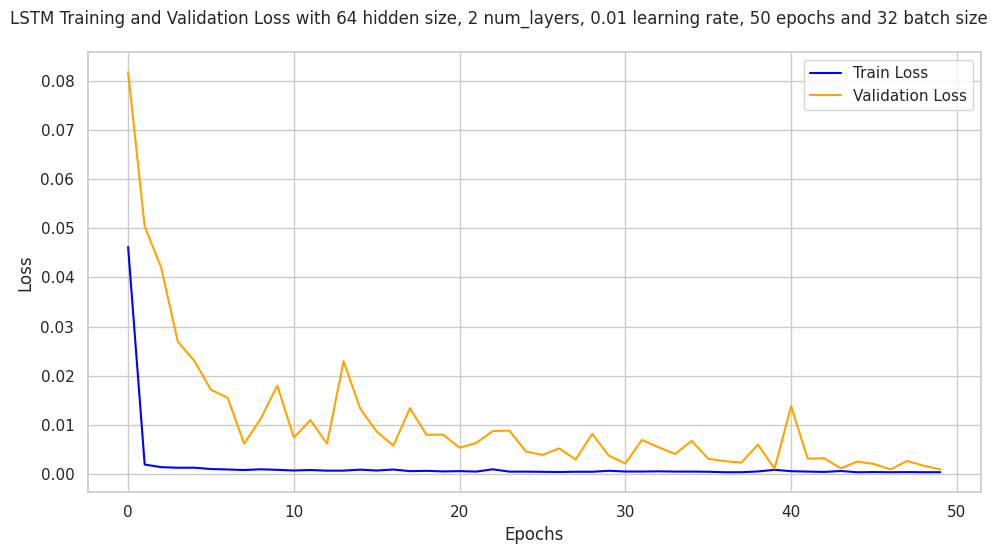

LSTM with 64 hidden size, 2 num_layers, 0.01 lr, 50 epochs and 32 batch size:
Test MSE: 121.3110, RMSE: 11.0141, MAE: 8.4470


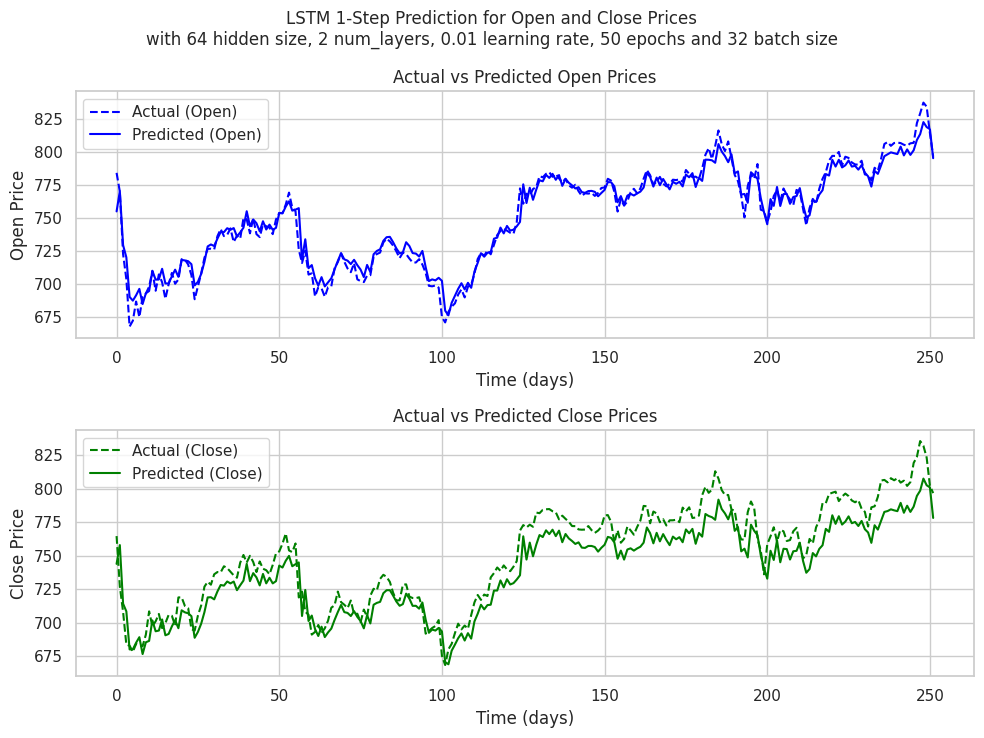

In [38]:
# Training and evaluation Phase for Models with N=5 and N=1

# Selected Best Hyperparameters for Vanilla RNN model
Vanilla_RNN_HP = {
    'hidden_size': 32,
    'num_layers': 1,
    'dropout_rate': 0.2,
    'learning_rate': 0.01,
    'batch_size': 32,
    'epochs': 50
}

# Selected Best Hyperparameters for GRU model
GRU_HP = {
    'hidden_size': 32,
    'num_layers': 2,
    'dropout_rate': 0.2,
    'learning_rate': 0.01,
    'batch_size': 32,
    'epochs': 50
}

# Selected Best Hyperparameters for LSTM model
LSTM_HP = {
    'hidden_size': 64,
    'num_layers': 2,
    'dropout_rate': 0.2,
    'learning_rate': 0.01,
    'batch_size': 32,
    'epochs': 50
}

M = 1  # Predict next time step (day)

# Run Vanilla RNN
print(f"Running Vanilla RNN with hidden_size={Vanilla_RNN_HP['hidden_size']}, num_layers={Vanilla_RNN_HP['num_layers']}, dropout_rate={Vanilla_RNN_HP['dropout_rate']}, "
      f"learning_rate={Vanilla_RNN_HP['learning_rate']}, batch_size={Vanilla_RNN_HP['batch_size']} and epochs={Vanilla_RNN_HP['epochs']}:")
vanilla_rnn_model = VanillaRNNPredictor(
    input_size=4,
    hidden_size=Vanilla_RNN_HP['hidden_size'],
    num_layers=Vanilla_RNN_HP['num_layers'],
    output_size=4,
    M=M,
    dropout_prob=Vanilla_RNN_HP['dropout_rate']
)
train_and_evaluate(
    vanilla_rnn_model, X_train, y_train, X_val, y_val, X_test, y_test,
    'Vanilla RNN', M, Vanilla_RNN_HP['hidden_size'], Vanilla_RNN_HP['num_layers'], Vanilla_RNN_HP['learning_rate'], Vanilla_RNN_HP['epochs'], Vanilla_RNN_HP['batch_size']
)

# Run GRU
print(f"Running GRU with hidden_size={GRU_HP['hidden_size']}, num_layers={GRU_HP['num_layers']}, dropout_rate={GRU_HP['dropout_rate']}, "
      f"learning_rate={GRU_HP['learning_rate']}, batch_size={GRU_HP['batch_size']} and epochs={GRU_HP['epochs']}:")
gru_model = GRUPredictor(
    input_size=4,
    hidden_size=GRU_HP['hidden_size'],
    num_layers=GRU_HP['num_layers'],
    output_size=4,
    M=M,
    dropout_prob=GRU_HP['dropout_rate']
)
train_and_evaluate(
    gru_model, X_train, y_train, X_val, y_val, X_test, y_test,
    'GRU', M, GRU_HP['hidden_size'], GRU_HP['num_layers'], GRU_HP['learning_rate'], GRU_HP['epochs'], GRU_HP['batch_size']
)

# Run LSTM
print(f"Running LSTM with hidden_size={LSTM_HP['hidden_size']}, num_layers={LSTM_HP['num_layers']}, dropout_rate={LSTM_HP['dropout_rate']}, "
      f"learning_rate={LSTM_HP['learning_rate']}, batch_size={LSTM_HP['batch_size']} and epochs={LSTM_HP['epochs']}:")
lstm_model = LSTMPredictor(
    input_size=4,
    hidden_size=LSTM_HP['hidden_size'],
    num_layers=LSTM_HP['num_layers'],
    output_size=4,
    M=M,
    dropout_prob=LSTM_HP['dropout_rate']
)
train_and_evaluate(
    lstm_model, X_train, y_train, X_val, y_val, X_test, y_test,
    'LSTM', M, LSTM_HP['hidden_size'], LSTM_HP['num_layers'], LSTM_HP['learning_rate'], LSTM_HP['epochs'], LSTM_HP['batch_size']
)

In [49]:
# Second Phase: Implementing RNN, GRU and LSTM on Google Stock data with (N=30, M=3 days) Sequence length
# Load the adjusted Google stock data
google_stock_data = pd.read_csv('/content/drive/Google_Stock_Data_Adjusted.csv')

# Display a sample to verify
print("Google Stock Data:\n",google_stock_data.head())

# Drop the 'Date' and 'Volume' column tkeep stock prices onlt for training
google_stock_data = google_stock_data.drop(columns=['Date','Volume'])
print("\nGoogle stock prices data:\n", google_stock_data)

# Extract all features for modeling
data_values = google_stock_data.values

# Calculate split indices for 70% training, 10% validating and 20% testing
train_size = int(0.7 * len(data_values))
val_size = int(0.1 * len(data_values))
test_size = len(data_values) - train_size - val_size

# Split data into train, validation, and test sets in chronological order for time series prediction
train_set = data_values[:train_size]
val_set = data_values[train_size:train_size + val_size]
test_set = data_values[train_size + val_size:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = scaler.fit_transform(train_set)
val_set_scaled = scaler.transform(val_set)
test_set_scaled = scaler.transform(test_set)

# Print datasets shapes to confirm
print(f"\nTrain set shape: {train_set_scaled.shape}")
print(f"Validation set shape: {val_set_scaled.shape}")
print(f"Test set shape: {test_set_scaled.shape}")

# Function to create sequences
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(N, len(data) - M + 1):
        X.append(data[i-N:i, :])  # Past N days
        y.append(data[i:i+M, :])  # Next M days
    return np.array(X), np.array(y)

# Set N (input sequence length) and M (output sequence length)
N = 30  # For past 30 days
M = 3   # to predict the next 3 days

# Create sequences for train, validation, and test sets
X_train, y_train = create_sequences(train_set_scaled, N, M)
X_val, y_val = create_sequences(val_set_scaled, N, M)
X_test, y_test = create_sequences(test_set_scaled, N, M)

# Print shapes
print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# To ensure reduciability with random seed 42
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# To ensure inputs are 3D (batch_size, sequence_length, input_size) for the training process
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

# Print shapes after reshaping data into 3D
print("\nAfter reshaping data to (batch_size, sequence_length, input_size):")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Google Stock Data:
          Date    Open    High     Low       Close      Volume
0  2012-01-03  325.25  332.83  324.97  331.463536   7380500.0
1  2012-01-04  331.27  333.87  329.08  332.892108   5749400.0
2  2012-01-05  329.83  330.75  326.89  328.276723   6590300.0
3  2012-01-06  328.34  328.77  323.68  323.796204   5405900.0
4  2012-01-09  322.04  322.29  309.46  310.069930  11688800.0

Google stock prices data:
         Open    High     Low       Close
0     325.25  332.83  324.97  331.463536
1     331.27  333.87  329.08  332.892108
2     329.83  330.75  326.89  328.276723
3     328.34  328.77  323.68  323.796204
4     322.04  322.29  309.46  310.069930
...      ...     ...     ...         ...
1273  829.62  835.77  825.06  835.670000
1274  837.81  838.00  827.01  832.150000
1275  834.71  841.95  820.44  823.310000
1276  814.66  815.84  799.80  802.320000
1277  796.86  801.25  790.52  796.790000

[1278 rows x 4 columns]

Train set shape: (894, 4)
Validation set shape: (127, 4)
Test 

In [50]:
# Define Vanilla RNN, GRU, and LSTM Models
class VanillaRNNPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, M, dropout_prob=0.2):
        super(VanillaRNNPredictor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, M* output_size)
        self.M = M
        self.output_size = output_size

    def forward(self,x):
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:,-1,:]) # Shape: (batch_size, M*output_size)
        out = out.view(-1,self.M, self.output_size)# Reshape output to (batch_size, M, output_size)
        return out

class GRUPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, M, dropout_prob=0.2):
        super(GRUPredictor, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, M* output_size)
        self.M = M
        self.output_size = output_size

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = out.view(-1, self.M, self.output_size)
        return out

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, M, dropout_prob=0.2):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, M * output_size)
        self.M = M
        self.output_size = output_size

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = out.view(-1, self.M, self.output_size)
        return out

In [51]:
# Training and Evaluation Function
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, M, hidden_size, num_layers, learning_rate, epochs, batch_size):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)
    train_losses, val_losses = [], []

    # DataLoader
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss= 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()

        # Record metrics
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        print(f'{model_name} Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.suptitle(f'{model_name} Training and Validation Loss with {hidden_size} hidden size, {num_layers} num_layers, '
             f'{learning_rate} learning rate, {epochs} epochs and {batch_size} batch size', fontsize=12, y=0.95)
    plt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    # Evaluate on Test Set
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.to(device)).cpu().numpy()
        actuals = y_test.cpu().numpy()

        # Handle inverse scaling for multi step prediction plots
        preds = predictions.reshape(-1, M, predictions.shape[-1])
        acts = actuals.reshape(-1, M, actuals.shape[-1])

        # Perform inverse scaling for preds and acts
        preds = scaler.inverse_transform(preds.reshape(-1, preds.shape[-1]))
        acts = scaler.inverse_transform(acts.reshape(-1, acts.shape[-1]))

    # Perform inverse scaling for predictions and actuals to calculate meterics
    predictions_inv = scaler.inverse_transform(predictions.reshape(-1, predictions.shape[-1]))
    actuals_inv = scaler.inverse_transform(actuals.reshape(-1, actuals.shape[-1]))

    # Calculate evaluation metrics on inverse-scaled data
    mse = mean_squared_error(actuals_inv.reshape(-1), predictions_inv.reshape(-1))
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals_inv.reshape(-1), predictions_inv.reshape(-1))

    # Calculate evaluation metrics on scaled data
    # mse = mean_squared_error(actuals.reshape(-1), predictions.reshape(-1))
    # rmse = np.sqrt(mse)
    # mae = mean_absolute_error(actuals.reshape(-1), predictions.reshape(-1))

    print(f'{model_name} with {hidden_size} hidden size, {num_layers} num_layers, {learning_rate} lr, {epochs} epochs and {batch_size} batch size:\nTest MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

    # Plot Open and Close prices predictions
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Open Prices (Actual vs Predicted)
    axes[0].plot(acts[:, 0], label='Actual (Open)', color='blue', linestyle='--')
    axes[0].plot(preds[:, 0], label='Predicted (Open)', color='blue')
    axes[0].set_title('Actual vs Predicted Open Prices')
    axes[0].set_xlabel('Time (days)')
    axes[0].set_ylabel('Open Price')
    axes[0].legend()

    # Close Prices (Actual vs Predicted)
    axes[1].plot(acts[:, 3], label='Actual (Close)', color='green', linestyle='--')
    axes[1].plot(preds[:, 3], label='Predicted (Close)', color='green')
    axes[1].set_title('Actual vs Predicted Close Prices')
    axes[1].set_xlabel('Time (days)')
    axes[1].set_ylabel('Close Price')
    axes[1].legend()

    fig.suptitle(f'{model_name} {M}-Step Prediction for Open and Close Prices\nwith {hidden_size} hidden size, '
             f'{num_layers} num_layers, {learning_rate} learning rate, {epochs} epochs and {batch_size} batch size',
             fontsize=12, y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

Running Vanilla RNN with hidden_size=64, num_layers=1, dropout_rate=0, learning_rate=0.01, batch_size=32 and epochs=100:
Vanilla RNN Epoch 1/100, Train Loss: 0.0281, Val Loss: 0.0105
Vanilla RNN Epoch 2/100, Train Loss: 0.0011, Val Loss: 0.0071
Vanilla RNN Epoch 3/100, Train Loss: 0.0010, Val Loss: 0.0076
Vanilla RNN Epoch 4/100, Train Loss: 0.0009, Val Loss: 0.0043
Vanilla RNN Epoch 5/100, Train Loss: 0.0007, Val Loss: 0.0040
Vanilla RNN Epoch 6/100, Train Loss: 0.0007, Val Loss: 0.0065
Vanilla RNN Epoch 7/100, Train Loss: 0.0008, Val Loss: 0.0034
Vanilla RNN Epoch 8/100, Train Loss: 0.0007, Val Loss: 0.0036
Vanilla RNN Epoch 9/100, Train Loss: 0.0007, Val Loss: 0.0033
Vanilla RNN Epoch 10/100, Train Loss: 0.0006, Val Loss: 0.0063
Vanilla RNN Epoch 11/100, Train Loss: 0.0008, Val Loss: 0.0041
Vanilla RNN Epoch 12/100, Train Loss: 0.0008, Val Loss: 0.0053
Vanilla RNN Epoch 13/100, Train Loss: 0.0007, Val Loss: 0.0028
Vanilla RNN Epoch 14/100, Train Loss: 0.0007, Val Loss: 0.0049
Vanill

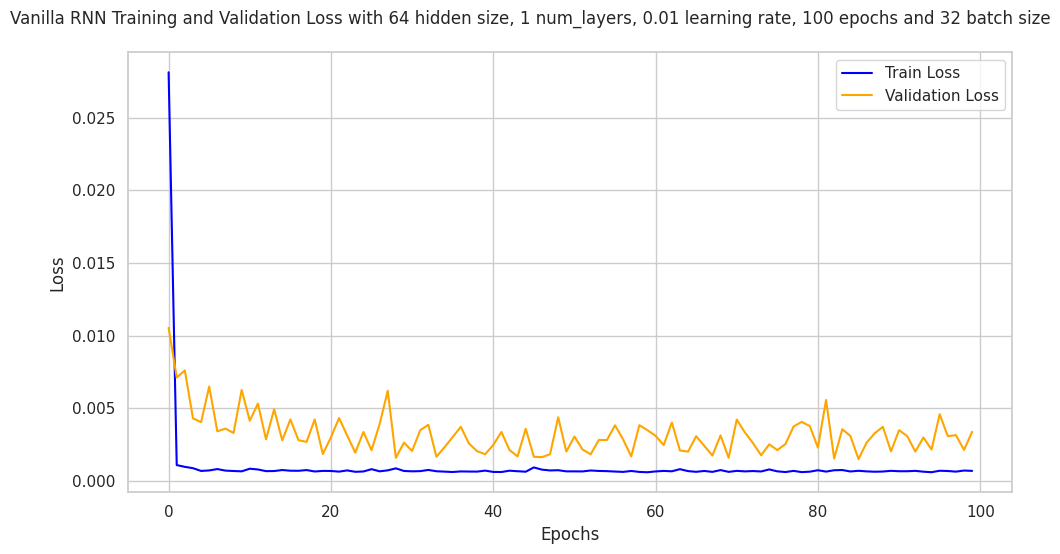

Vanilla RNN with 64 hidden size, 1 num_layers, 0.01 lr, 100 epochs and 32 batch size:
Test MSE: 786.6982, RMSE: 28.0481, MAE: 25.7513


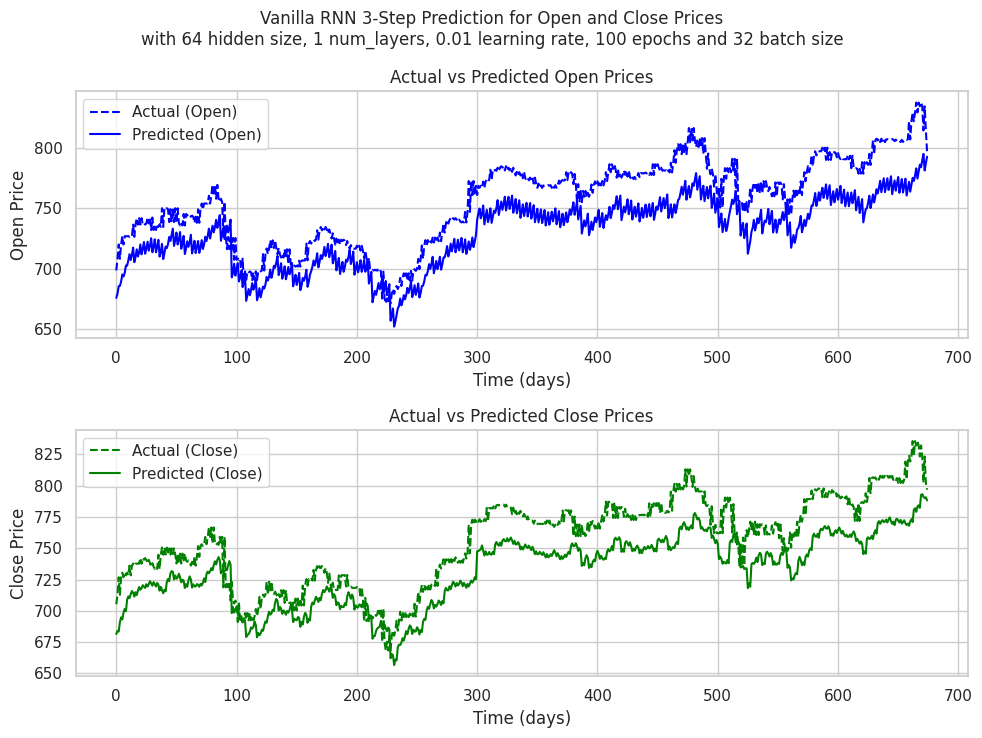

Running GRU with hidden_size=128, num_layers=1, dropout_rate=0, learning_rate=0.01, batch_size=32 and epochs=100:
GRU Epoch 1/100, Train Loss: 0.0294, Val Loss: 0.0042
GRU Epoch 2/100, Train Loss: 0.0011, Val Loss: 0.0018
GRU Epoch 3/100, Train Loss: 0.0007, Val Loss: 0.0018
GRU Epoch 4/100, Train Loss: 0.0007, Val Loss: 0.0024
GRU Epoch 5/100, Train Loss: 0.0006, Val Loss: 0.0017
GRU Epoch 6/100, Train Loss: 0.0007, Val Loss: 0.0018
GRU Epoch 7/100, Train Loss: 0.0006, Val Loss: 0.0017
GRU Epoch 8/100, Train Loss: 0.0007, Val Loss: 0.0028
GRU Epoch 9/100, Train Loss: 0.0007, Val Loss: 0.0021
GRU Epoch 10/100, Train Loss: 0.0007, Val Loss: 0.0016
GRU Epoch 11/100, Train Loss: 0.0006, Val Loss: 0.0022
GRU Epoch 12/100, Train Loss: 0.0006, Val Loss: 0.0021
GRU Epoch 13/100, Train Loss: 0.0007, Val Loss: 0.0028
GRU Epoch 14/100, Train Loss: 0.0007, Val Loss: 0.0023
GRU Epoch 15/100, Train Loss: 0.0007, Val Loss: 0.0018
GRU Epoch 16/100, Train Loss: 0.0007, Val Loss: 0.0023
GRU Epoch 17/10

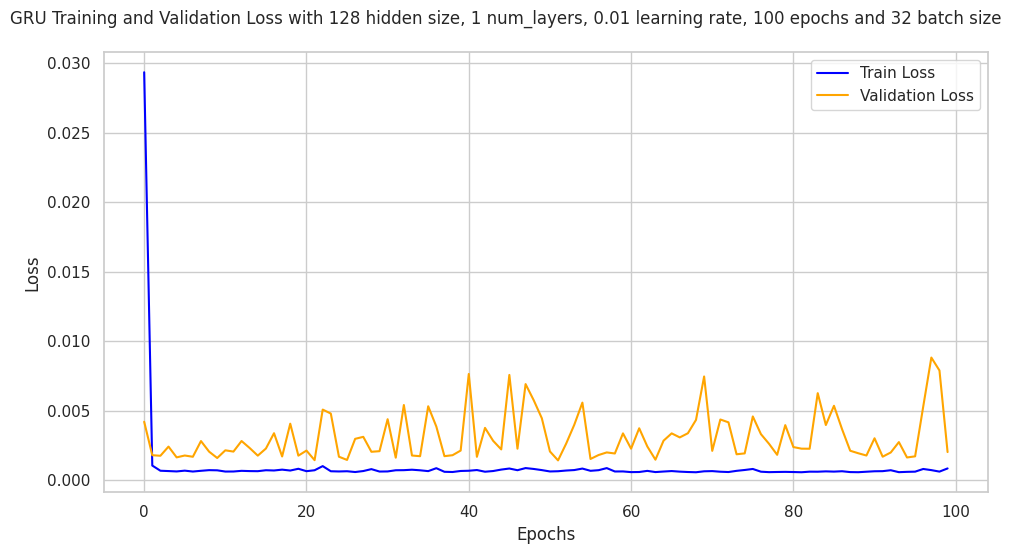

GRU with 128 hidden size, 1 num_layers, 0.01 lr, 100 epochs and 32 batch size:
Test MSE: 306.8054, RMSE: 17.5159, MAE: 14.1209


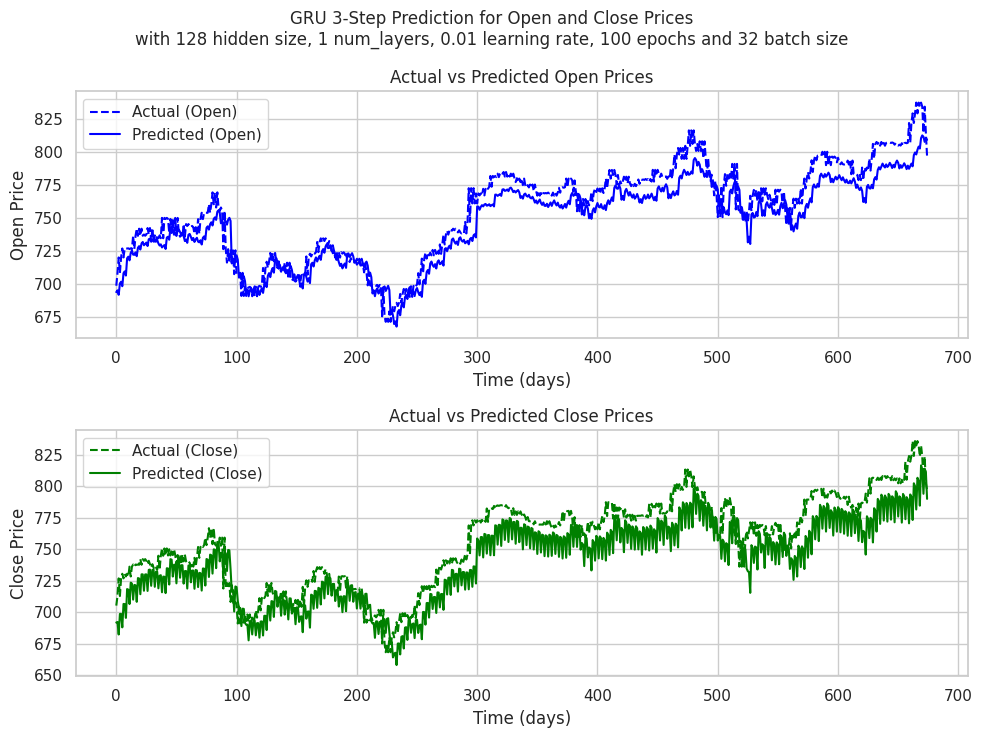

Running LSTM with hidden_size=128, num_layers=1, dropout_rate=0, learning_rate=0.01, batch_size=32 and epochs=100:
LSTM Epoch 1/100, Train Loss: 0.0764, Val Loss: 0.0219
LSTM Epoch 2/100, Train Loss: 0.0017, Val Loss: 0.0234
LSTM Epoch 3/100, Train Loss: 0.0009, Val Loss: 0.0212
LSTM Epoch 4/100, Train Loss: 0.0009, Val Loss: 0.0160
LSTM Epoch 5/100, Train Loss: 0.0009, Val Loss: 0.0101
LSTM Epoch 6/100, Train Loss: 0.0008, Val Loss: 0.0090
LSTM Epoch 7/100, Train Loss: 0.0009, Val Loss: 0.0073
LSTM Epoch 8/100, Train Loss: 0.0008, Val Loss: 0.0054
LSTM Epoch 9/100, Train Loss: 0.0008, Val Loss: 0.0056
LSTM Epoch 10/100, Train Loss: 0.0007, Val Loss: 0.0032
LSTM Epoch 11/100, Train Loss: 0.0008, Val Loss: 0.0038
LSTM Epoch 12/100, Train Loss: 0.0007, Val Loss: 0.0034
LSTM Epoch 13/100, Train Loss: 0.0007, Val Loss: 0.0043
LSTM Epoch 14/100, Train Loss: 0.0007, Val Loss: 0.0034
LSTM Epoch 15/100, Train Loss: 0.0007, Val Loss: 0.0047
LSTM Epoch 16/100, Train Loss: 0.0007, Val Loss: 0.003

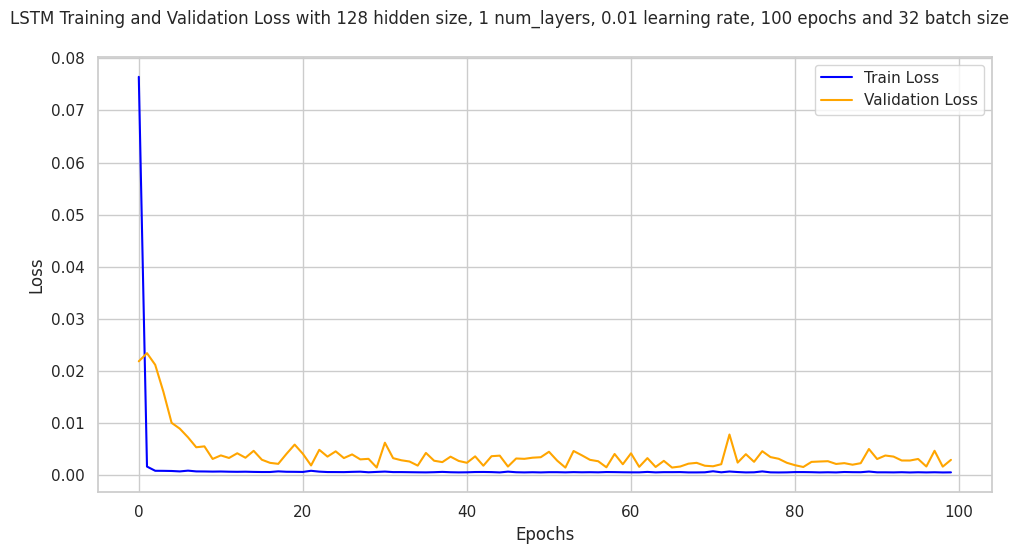

LSTM with 128 hidden size, 1 num_layers, 0.01 lr, 100 epochs and 32 batch size:
Test MSE: 666.2817, RMSE: 25.8124, MAE: 22.5821


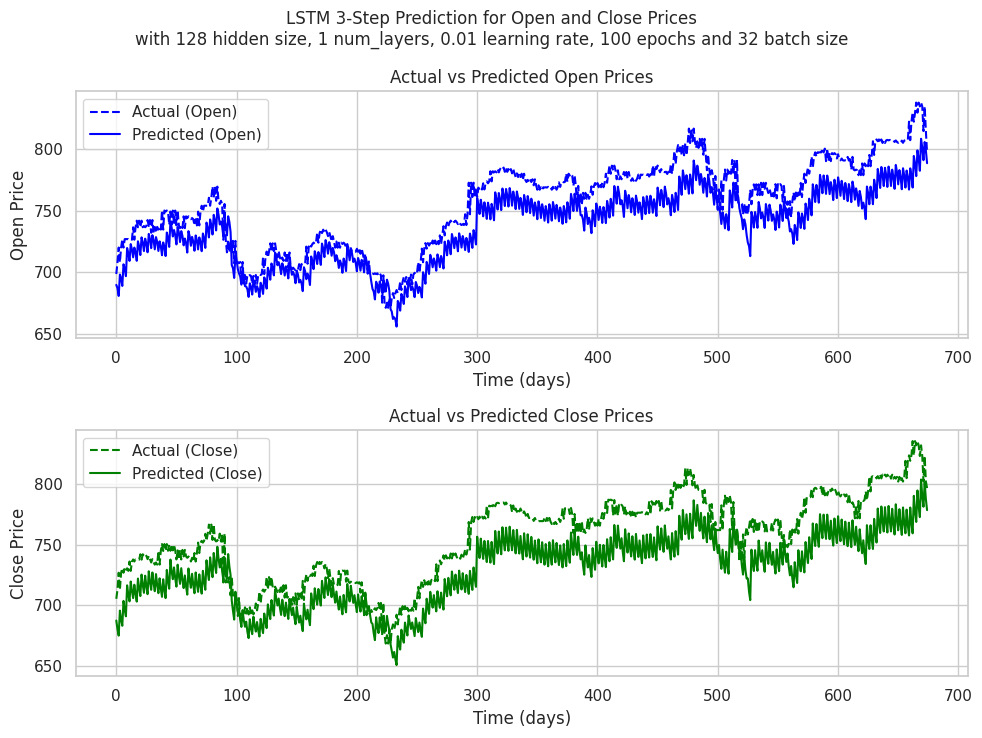

In [65]:
# Training and evaluation Phase for Models with N=30 and M=3

# Selected Best Hyperparameters for Vanilla RNN model
Vanilla_RNN_HP = {
    'hidden_size': 64,
    'num_layers': 1,
    'dropout_rate': 0,
    'learning_rate': 0.01,
    'batch_size': 32,
    'epochs': 100
}

# Selected Best Hyperparameters for GRU model
GRU_HP = {
    'hidden_size': 128,
    'num_layers': 1,
    'dropout_rate': 0,
    'learning_rate': 0.01,
    'batch_size': 32,
    'epochs': 100
}

# Selected Best Hyperparameters for LSTM model
LSTM_HP = {
    'hidden_size': 128,
    'num_layers': 1,
    'dropout_rate': 0,
    'learning_rate': 0.01,
    'batch_size': 32,
    'epochs': 100
}

M =3  # Predict next 3 time steps (days)

# Run Vanilla RNN
print(f"Running Vanilla RNN with hidden_size={Vanilla_RNN_HP['hidden_size']}, num_layers={Vanilla_RNN_HP['num_layers']}, dropout_rate={Vanilla_RNN_HP['dropout_rate']}, "
      f"learning_rate={Vanilla_RNN_HP['learning_rate']}, batch_size={Vanilla_RNN_HP['batch_size']} and epochs={Vanilla_RNN_HP['epochs']}:")
vanilla_rnn_model = VanillaRNNPredictor(
    input_size=4,
    hidden_size=Vanilla_RNN_HP['hidden_size'],
    num_layers=Vanilla_RNN_HP['num_layers'],
    output_size=4,
    M=M,
    dropout_prob=Vanilla_RNN_HP['dropout_rate']
)
train_and_evaluate(
    vanilla_rnn_model, X_train, y_train, X_val, y_val, X_test, y_test,
    'Vanilla RNN', M, Vanilla_RNN_HP['hidden_size'], Vanilla_RNN_HP['num_layers'], Vanilla_RNN_HP['learning_rate'], Vanilla_RNN_HP['epochs'], Vanilla_RNN_HP['batch_size']
)

# Run GRU
print(f"Running GRU with hidden_size={GRU_HP['hidden_size']}, num_layers={GRU_HP['num_layers']}, dropout_rate={GRU_HP['dropout_rate']}, "
      f"learning_rate={GRU_HP['learning_rate']}, batch_size={GRU_HP['batch_size']} and epochs={GRU_HP['epochs']}:")
gru_model = GRUPredictor(
    input_size=4,
    hidden_size=GRU_HP['hidden_size'],
    num_layers=GRU_HP['num_layers'],
    output_size=4,
    M=M,
    dropout_prob=GRU_HP['dropout_rate']
)
train_and_evaluate(
    gru_model, X_train, y_train, X_val, y_val, X_test, y_test,
    'GRU', M, GRU_HP['hidden_size'], GRU_HP['num_layers'], GRU_HP['learning_rate'], GRU_HP['epochs'], GRU_HP['batch_size']
)

# Run LSTM
print(f"Running LSTM with hidden_size={LSTM_HP['hidden_size']}, num_layers={LSTM_HP['num_layers']}, dropout_rate={LSTM_HP['dropout_rate']}, "
      f"learning_rate={LSTM_HP['learning_rate']}, batch_size={LSTM_HP['batch_size']} and epochs={LSTM_HP['epochs']}:")
lstm_model = LSTMPredictor(
    input_size=4,
    hidden_size=LSTM_HP['hidden_size'],
    num_layers=LSTM_HP['num_layers'],
    output_size=4,
    M=M,
    dropout_prob=LSTM_HP['dropout_rate']
)
train_and_evaluate(
    lstm_model, X_train, y_train, X_val, y_val, X_test, y_test,
    'LSTM', M, LSTM_HP['hidden_size'], LSTM_HP['num_layers'], LSTM_HP['learning_rate'], LSTM_HP['epochs'], LSTM_HP['batch_size']
)

## References:
[1] “Alphabet (Google) Stock Splits,” *CompaniesMarketCap*, 2024. [Online]. Available: https://companiesmarketcap.com/alphabet-google/stock-splits/. [Accessed: Dec. 3, 2024].

[2] R. Saldanha, "stock-prediction-pytorch," *GitHub Repository*, 2019. [Online]. Available: https://github.com/RodolfoLSS/stock-prediction-pytorch. [Accessed: Dec. 3, 2024].

[3] A. Tam, "LSTM for Time Series Prediction in PyTorch," *Machine Learning Mastery*, Apr. 8, 2023. [Online]. Available: https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/. [Accessed: Dec. 3, 2024].
